# $\text{CO}_2 \text{ Emissions Trend Analysis}$ 

## **Setup**

#### **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### **Loading Data**


In [2]:
df = pd.read_csv('annual_global_CO2_levels', 
                 delimiter = "\t", 
                 names = ["Year", "CO2 Level"], 
                 skiprows = 1)

#### **Graphing Data**

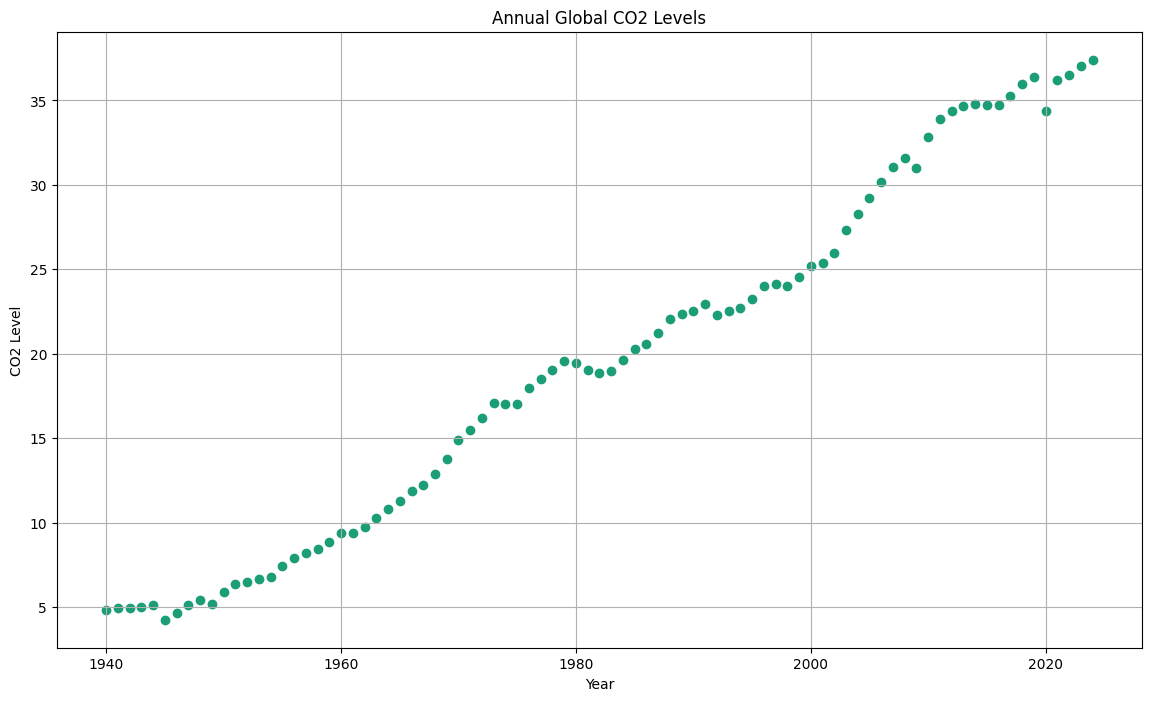

In [3]:
plt.figure(figsize = (14, 8))
plt.scatter(df['Year'], df['CO2 Level'], color = '#1b9e77', label = 'Data')
plt.xlabel('Year')
plt.ylabel('CO2 Level')
plt.title('Annual Global CO2 Levels')
plt.grid(True)
plt.show()

#### **Scaling Data**

Scaling is required here because the x-values are in thousands and the y-values are in single or double digits.

In [4]:
x_values = df['Year'].values.astype(np.float32)
x_values = (x_values - x_values.min()) / (x_values.max() - x_values.min())

y_values = df['CO2 Level'].values.astype(np.float32)
y_values = (y_values - y_values.min()) / (y_values.max() - y_values.min())

#### **Splitting Data**

Splitting the data into training, validation, and testing sets.

In [5]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_values, y_values, test_size = 0.2, random_state = 13)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.2, random_state = 13)

## **Model Selection**

When selecting models, I considered two key factors. Firstly, I ensured that the loss function is convex, meaning it has a single minimum. This is important because it guarantees that the optimization process will converge to the global minimum, avoiding the risk of getting stuck in a local minimum. Secondly, I ensured that the model’s complexity was appropriate. A model that is too complex may overfit the data, capturing noise rather than general patterns, while a model that is too simple may underfit, failing to capture the underlying relationships in the data.

Based on the visual analysis of the annual global CO2 levels data, a *linear model* would be a logical starting point for this analysis. The overall trend of the data appears to be relatively linear, exhibiting a steady, consistent increase in CO2 emissions over the decades. While the data points do not perfectly align with a straight line, a linear model can still serve as a reasonable approximation to capture the general upward trajectory. Fitting a linear model will provide insights into the average rate of change in CO2 levels and establish a baseline for comparison against more complex modeling approaches.

To capture the nuances and potential fluctuations in the emissions trend more accurately, a *sinusoidal model* may be a valuable addition to the analysis. The data appears to show some periodic or cyclical patterns, which could be indicative of underlying factors influencing the CO2 levels over time. A sinusoidal model, with its wave-like behavior, can help identify and quantify any recurring components in the emissions data that may not be fully captured by a linear model alone.

Considering the overall increasing nature of the CO2 levels, an *exponential model* may also be worth exploring. Exponential growth functions are often used to describe phenomena that exhibit compounding increases, which could be the case for global emissions. However, on the other hand, if a decrease in population growth is projected, or if significant changes in energy consumption patterns are anticipated, a *square root model* may be more appropriate. This model type can capture a decelerating growth rate, reflecting a potential slowdown in CO2 emissions as global dynamics shift.

So for this project, we will analyze and compare the performance of **linear, sinusoidal, exponential, and square root models** to determine the best fit for the CO2 emissions trend data.

## **Error Metrics Selection**

Mean Absolute Error (MAE) is a robust and interpretable loss function that quantifies the average magnitude of errors between predicted and actual values. Unlike Mean Squared Error (MSE), MAE treats all errors equally by measuring their absolute value, making it less sensitive to outliers. Given the potential for noise or anomalies in global CO2 emissions data, MAE ensures that a few extreme data points do not disproportionately influence the gradient descent optimization. This aligns well with our objective to understand general trends rather than overfitting to specific irregularities in the dataset.

$$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$

Note: If we were to make an optimized machine learning model, we would probably use the Mean Squared Error (MSE) as our loss function. This is because the MSE is differentiable, which is required for gradient descent optimization.

## **Modeling**

### **Linear Model**

The linear model's equation:

$$y = mx + b$$

In [6]:
# linear function
def linearModel(m: float, b: float, x:np.ndarray) -> float:
    return m * x + b

To visualize the initial model, we set arbitrary values for $m$ and $b$ that provide a rough approximation of the data trend:

In [7]:
# Initial parameter values
m = 1.0
b = 0.0

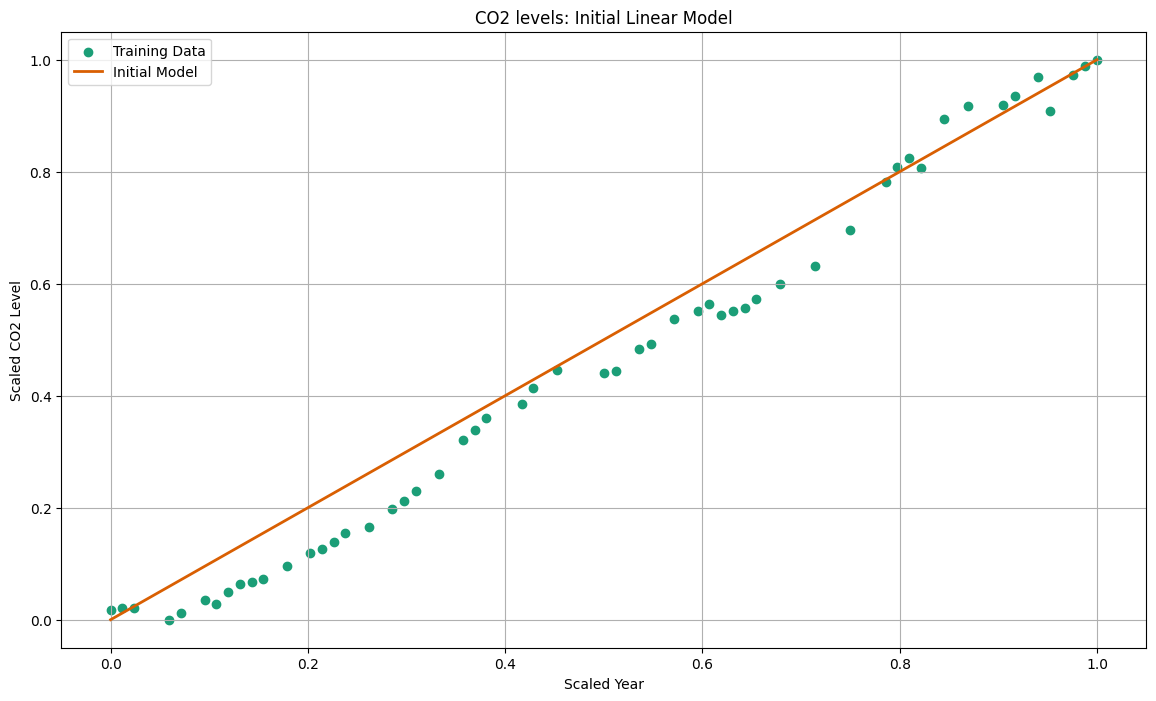

In [8]:
x = np.linspace(0, 1, 100)
y = linearModel(m, b, x)

plt.figure(figsize = (14, 8))
plt.scatter(x_train, y_train, color = '#1b9e77', label = 'Training Data')
plt.plot(x, y, linewidth = 2, color = '#d95f02', label = 'Initial Model')
plt.xlabel('Scaled Year')
plt.ylabel('Scaled CO2 Level')
plt.title('CO2 levels: Initial Linear Model')
plt.legend()
plt.grid(True)
plt.show()

This visualization provides a baseline for comparison and a starting point for optimization. The next step is to apply gradient descent to iteratively refine $m$ and $b$, minimizing the error between the predicted and actual values.

#### **Gradient Descent**

For this task, we aim to minimize the Mean Absolute Error (MAE) between the predicted and actual CO2 levels. The MAE is defined as:

$$ E = \frac{1}{n} \sum_{i=1}^{n} |[mx_i + b] - y_i| $$

In [9]:
def linearError(m: float, b: float, x:np.ndarray, y:np.ndarray) -> float:
    return np.mean((np.abs(linearModel(m, b, x) - y)))

The partial derivatives of the MAE with respect to $m$ and $b$ are computed as follows:

$$ \frac{\partial E}{\partial m} = \frac{1}{n} \sum_{i=1}^{n} \text{sign}([mx_i + b] - y_i) \cdot x_i $$ 

$$ \frac{\partial E}{\partial b} = \frac{1}{n} \sum_{i=1}^{n} \text{sign}([mx_i + b] - y_i) $$

These gradients guide the update of $m$ and $b$ to decrease error.

Before starting the optimization loop, we define hyperparameters for the learning rate and number of iterations (epochs):

In [10]:
# Hyperparameters
learning_rate = 1E-3
epochs = 50

In [11]:
# Track losses
training_loss = []
validation_loss = []

# Gradient descent loop
for epoch in range(epochs):
    # Compute predictions for the training set
    y_pred_train = linearModel(m, b, x_train)
    
    # Compute gradients
    dm = np.mean(np.sign(y_pred_train - y_train) * x_train)
    db = np.mean(np.sign(y_pred_train - y_train))
    
    # Update parameters
    m -= learning_rate * dm
    b -= learning_rate * db
    
    # Compute training loss
    loss = linearError(m, b, x_train, y_train)
    training_loss.append(loss)
    
    # Compute validation loss
    y_pred_val = linearModel(m, b, x_val)
    val_loss = linearError(m, b, x_val, y_val)
    validation_loss.append(val_loss)
    
    # Log progress
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Training Loss = {loss:.4f}, Validation Loss = {val_loss:.4f}')
        
# Print final results
print("---------------------------------------")
print(f'Final Training Loss: {linearError(m, b, x_train, y_train):.4f}')
print(f'Final Validation Loss: {linearError(m, b, x_val, y_val):.4f}')
print(f'Optimized Parameters: m = {m:.4f}, b = {b:.4f}')

Epoch 0: Training Loss = 0.0498, Validation Loss = 0.0485
Epoch 10: Training Loss = 0.0468, Validation Loss = 0.0453
Epoch 20: Training Loss = 0.0447, Validation Loss = 0.0433
Epoch 30: Training Loss = 0.0430, Validation Loss = 0.0418
Epoch 40: Training Loss = 0.0416, Validation Loss = 0.0411
---------------------------------------
Final Training Loss: 0.0406
Final Validation Loss: 0.0411
Optimized Parameters: m = 0.9956, b = -0.0212


#### **Convergence Criteria**

To ensure the gradient descent algorithm has converged, we analyze the progression of the loss (error) on both the training and validation sets across epochs. Convergence is achieved when the losses stabilize, indicating that further iterations yield minimal improvement.

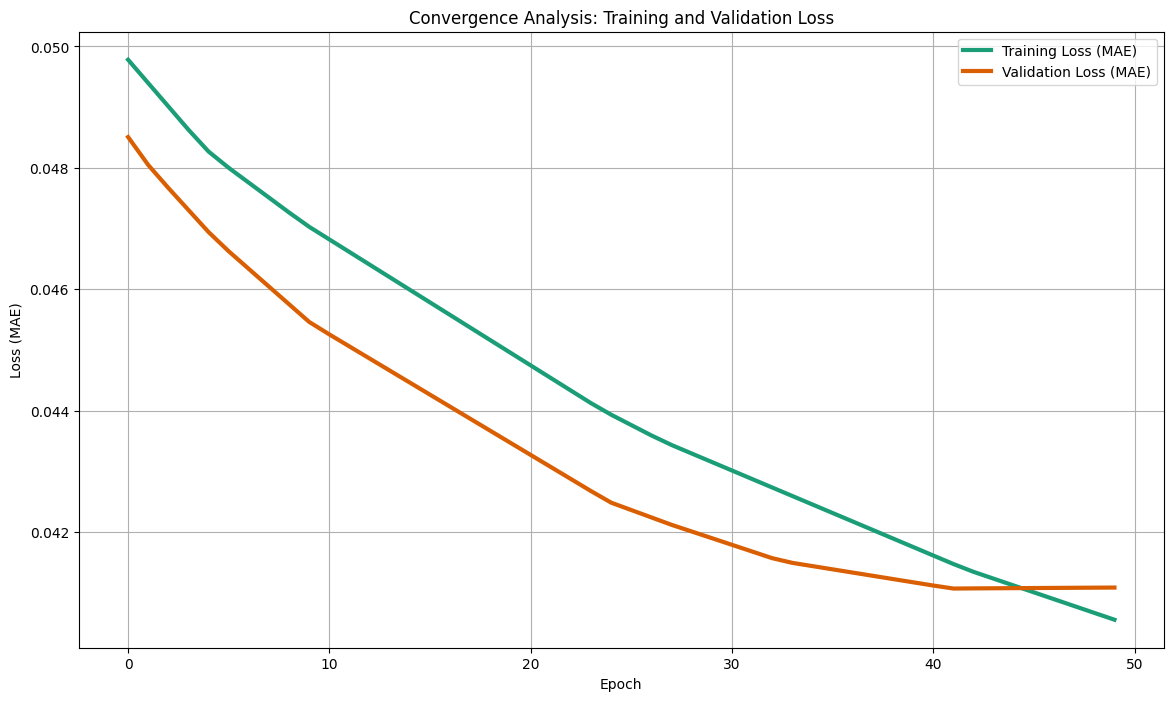

In [12]:
# Plot training and validation losses
plt.figure(figsize=(14, 8))
plt.plot(training_loss, label='Training Loss (MAE)', linewidth=3, color='#1b9e77')
plt.plot(validation_loss, label='Validation Loss (MAE)', linewidth=3, color='#d95f02')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Convergence Analysis: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Both training and validation losses decrease sharply during the first few epochs, indicating that the model is effectively learning the general trend of the data. By approximately 40 epochs, the validation loss plateaus, showing minimal further change. This stabilization is a key indicator of convergence, as the model parameters reach an optimal configuration with respect to the given data. The gap between training and validation losses is small, suggesting that the model generalizes well without significant overfitting or underfitting.

This outcome validates the chosen hyperparameters (learning rate, epochs) and confirms the stability of the optimization process.

#### **Model Testing & Error Analysis**

To test the linear model's performance, we evaluate its predictions on the test set and calculate the Mean Absolute Error (MAE) to quantify the average deviation between predicted and actual CO2 levels. The MAE provides a clear measure of the model's accuracy and generalization capability on unseen data.

Final Test Loss (MAE): 0.0371


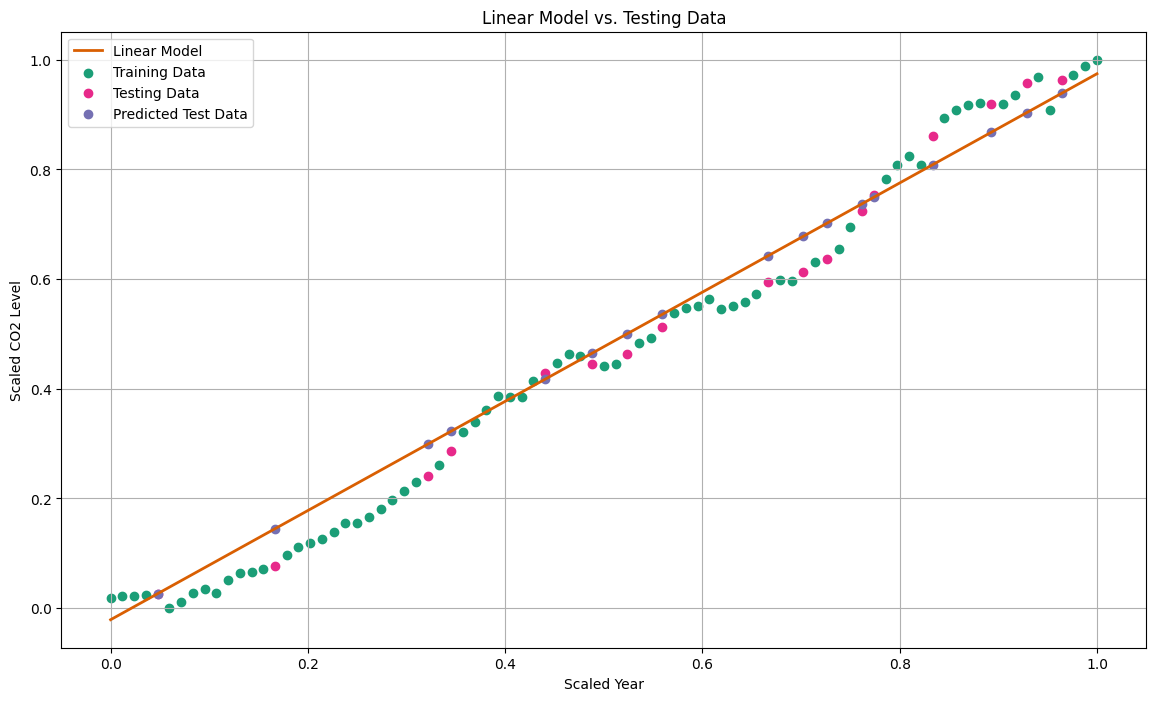

In [13]:
x = np.linspace(0, 1, 100)
y = linearModel(m, b, x)

# Evaluate the model on the test set
y_pred_test = linearModel(m, b, x_test)
test_loss = linearError(m, b, x_test, y_test)

# Print the test loss
print(f"Final Test Loss (MAE): {test_loss:.4f}")

# Plot the model's predictions against the test data
plt.figure(figsize=(14, 8))
plt.plot(x, y, linewidth=2, color='#d95f02', label='Linear Model')
plt.scatter(x_train_val, y_train_val, color='#1b9e77', label='Training Data')
plt.scatter(x_test, y_test, color='#e7298a', label='Testing Data')
plt.scatter(x_test, y_pred_test, color='#7570b3', label='Predicted Test Data')
plt.xlabel('Scaled Year')
plt.ylabel('Scaled CO2 Level')
plt.title('Linear Model vs. Testing Data')
plt.legend()
plt.grid(True)
plt.show()

The linear model performed well across all datasets, achieving a Mean Absolute Error (MAE) of 4.0% on the training set, 4.1% on the validation set, and 3.71% on the testing set. The small difference between training, validation, and testing losses indicates that the model generalizes effectively to unseen data, with no signs of significant overfitting or underfitting.

Final model:

$$ y = 0.995x - 0.02 $$

The final model captures the consistent upward trend in CO2 emissions over time. The positive slope of 0.995 reflects the steady increase in emissions, aligning with global patterns of industrialization and population growth.

While the linear model is simple and interpretable, it may not fully capture potential nonlinear or cyclical variations in the data. Nonetheless, its low error and strong generalization make it a solid baseline for comparison with more complex models, such as sinusoidal or exponential, which will be explored next.

---

### **Sinusoidal Model**

The sinusoidal (sin) model is defined as:

$$ y = a \sin(bx + c) + d $$

In [14]:
# Sin function
def sinModel(a: float, b: float, c: float, d: float, x: np.ndarray) -> np.ndarray:
    return a * np.sin(b * x + c) + d

Setting arbitrary initial values for the parameters:

In [15]:
# Initial parameter values
a = 1.2
b = 1.0
c = 0.0
d = 0.0

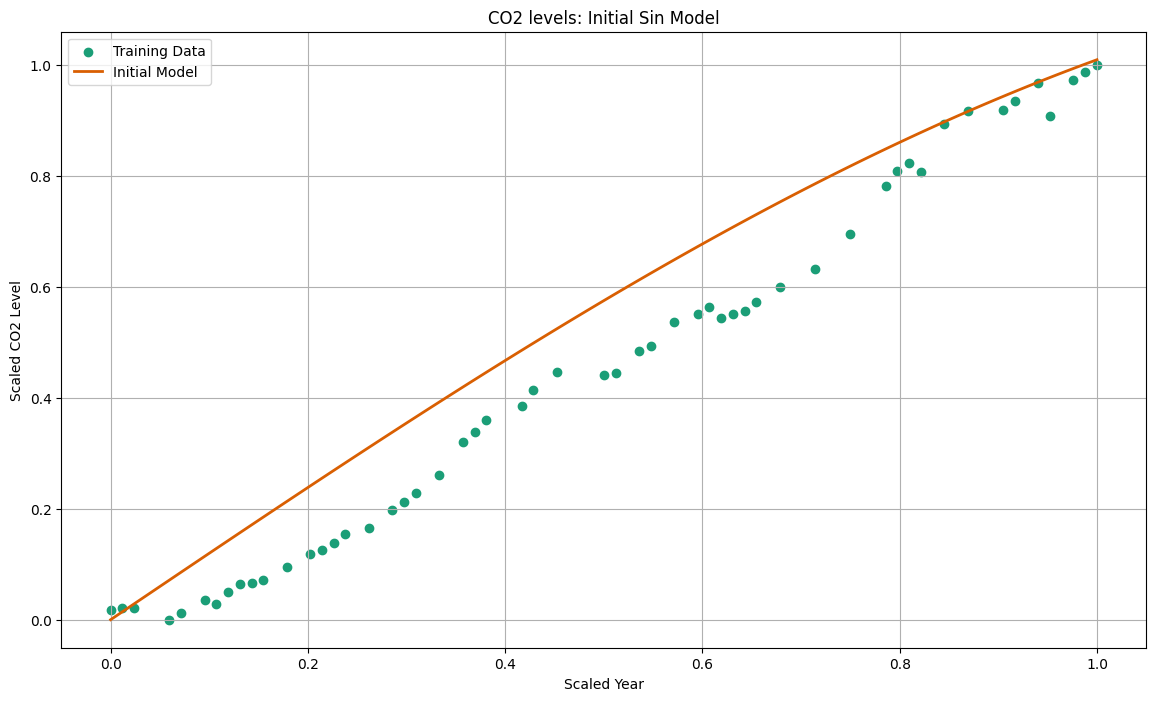

In [16]:
x = np.linspace(0, 1, 100)
y = sinModel(a, b, c, d, x)

plt.figure(figsize = (14, 8))
plt.scatter(x_train, y_train, color = '#1b9e77', label = 'Training Data')
plt.plot(x, y, linewidth = 2, color = '#d95f02', label = 'Initial Model')
plt.xlabel('Scaled Year')
plt.ylabel('Scaled CO2 Level')
plt.title('CO2 levels: Initial Sin Model')
plt.legend()
plt.grid(True)
plt.show()

Seems like a good starting point for the sinusoidal model. The next step is to optimize these parameters using gradient descent to minimize the Mean Absolute Error (MAE) between the predicted and actual CO2 levels.

#### **Gradient Descent**

We aim to minimize the Mean Absolute Error (MAE) between the predicted and actual CO2 levels. The MAE is defined as:

$$ E = \frac{1}{n} \sum_{i=1}^{n} |[a \sin(bx_i+c) + d] - y_i| $$

In [17]:
def sinError(a: float, b: float, c:float, d:float, x:np.ndarray, y:np.ndarray) -> float:
    return np.mean((np.abs(sinModel(a, b, c, d, x) - y)))

The partial derivatives of the MAE with respect to $a$, $b$, $c$, and $d$ are computed as follows:

$$ \frac{\partial E}{\partial a} = \frac{1}{n} \sum_{i=1}^{n} \text{sign}([a \sin(bx_i+c) + d] - y_i) \cdot \sin(bx_i+c) $$

$$ \frac{\partial E}{\partial b} = \frac{1}{n} \sum_{i=1}^{n} \text{sign}([a \sin(bx_i+c) + d] - y_i) \cdot a \cos(bx_i+c) \cdot x_i $$

$$ \frac{\partial E}{\partial c} = \frac{1}{n} \sum_{i=1}^{n} \text{sign}([a \sin(bx_i+c) + d] - y_i) \cdot a \cos(bx_i+c) $$

$$ \frac{\partial E}{\partial d} = \frac{1}{n} \sum_{i=1}^{n} \text{sign}([a \sin(bx_i+c) + d] - y_i) $$

These gradients guide the update of $a$, $b$, $c$, and $d$ to decrease error.

Before starting the optimization loop, we define hyperparameters for the learning rate and number of iterations (epochs):

In [18]:
# Hyperparameters
learning_rate = 1E-4
epochs = 800

In [19]:
# Track losses
training_loss = []
validation_loss = []

# Gradient descent loop
for epoch in range(epochs):
    # Compute predictions for the training set
    y_pred_train = sinModel(a, b, c, d, x_train)
    
    # Compute gradients
    da = np.mean(np.sign(y_pred_train - y_train) * np.sin(b * x_train + c))
    db = np.mean(np.sign(y_pred_train - y_train) * a * x_train * np.cos(b * x_train + c))
    dc = np.mean(np.sign(y_pred_train - y_train) * a * np.cos(b * x_train + c))
    dd = np.mean(np.sign(y_pred_train - y_train))
    
    # Update parameters
    a -= learning_rate * da
    b -= learning_rate * db
    c -= learning_rate * dc
    d -= learning_rate * dd
    
    # Compute training loss
    loss = sinError(a, b, c, d, x_train, y_train)
    training_loss.append(loss)
    
    # Compute validation loss
    y_pred_val = sinModel(a, b, c, d, x_val)
    val_loss = sinError(a, b, c, d, x_val, y_val)
    validation_loss.append(val_loss)
    
    # Log progress
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Training Loss = {loss:.4f}, Validation Loss = {val_loss:.4f}')
        
# Print final results
print("---------------------------------------")
print(f'Final Training Loss: {sinError(a, b, c, d, x_train, y_train):.4f}')
print(f'Final Validation Loss: {sinError(a, b, c, d, x_val, y_val):.4f}')
print(f'Optimized Parameters: a = {a:.4f}, b = {b:.4f}, c = {c:.4f}, d = {d:.4f}')

Epoch 0: Training Loss = 0.0918, Validation Loss = 0.0900
Epoch 100: Training Loss = 0.0771, Validation Loss = 0.0757
Epoch 200: Training Loss = 0.0675, Validation Loss = 0.0665
Epoch 300: Training Loss = 0.0589, Validation Loss = 0.0580
Epoch 400: Training Loss = 0.0518, Validation Loss = 0.0503
Epoch 500: Training Loss = 0.0456, Validation Loss = 0.0438
Epoch 600: Training Loss = 0.0429, Validation Loss = 0.0423
Epoch 700: Training Loss = 0.0417, Validation Loss = 0.0417
---------------------------------------
Final Training Loss: 0.0407
Final Validation Loss: 0.0422
Optimized Parameters: a = 1.1897, b = 0.9860, c = -0.0429, d = -0.0367


#### **Convergence Criteria**

To ensure the gradient descent algorithm has converged, we analyze the progression of the loss (error) on both the training and validation sets across epochs. Convergence is achieved when the losses stabilize, indicating that further iterations yield minimal improvement.

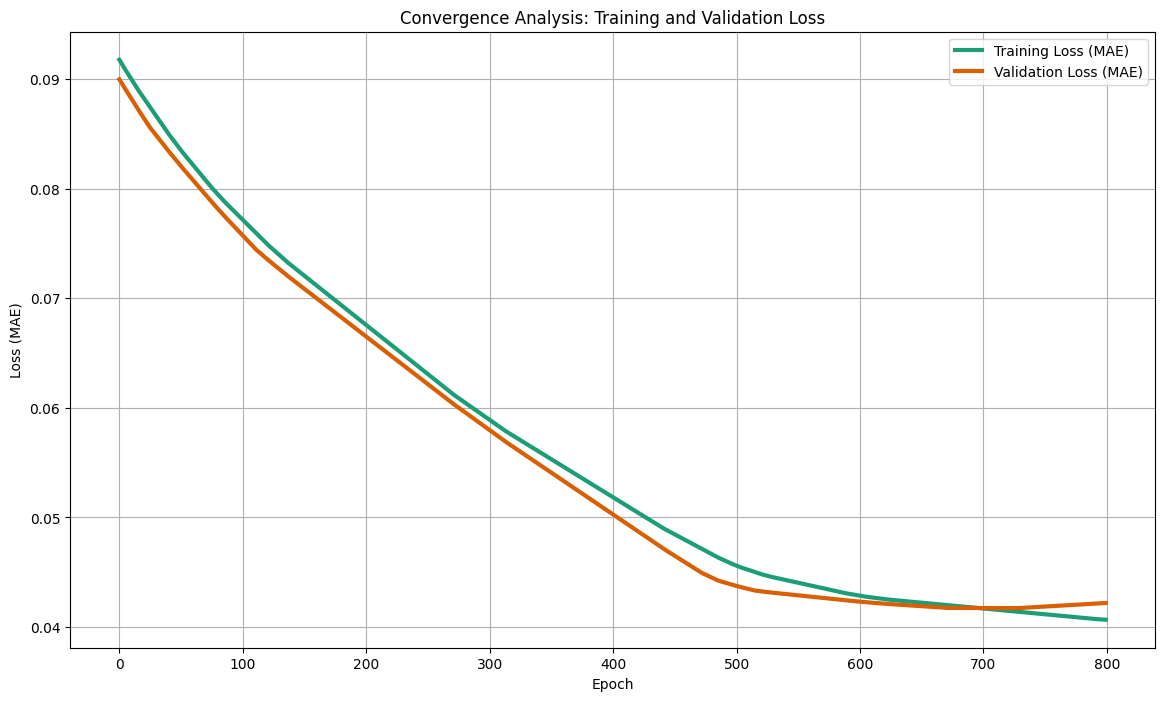

In [20]:
# Plot training and validation losses
plt.figure(figsize=(14, 8))
plt.plot(training_loss, label='Training Loss (MAE)', linewidth=3, color='#1b9e77')
plt.plot(validation_loss, label='Validation Loss (MAE)', linewidth=3, color='#d95f02')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Convergence Analysis: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Both training and validation losses decrease sharply, indicating that the model is effectively learning the general trend of the data. By approximately 700 epochs, the validation loss plateaus, showing minimal further change. This stabilization is a key indicator of convergence, as the model parameters reach an optimal configuration with respect to the given data. A key observation is that the sinusoidal model's training and validation losses difference is smaller than our linear model, suggesting that the sinusoidal model may generalize better to unseen data, and has a lower risk of overfitting.

This outcome validates the chosen hyperparameters (learning rate, epochs) and confirms the stability of the optimization process.

#### **Model Testing & Error Analysis**

Let's evaluate the sinusoidal model's performance on the test set and calculate the Mean Absolute Error (MAE) to quantify the average deviation between predicted and actual CO2 levels.

Final Test Loss (MAE): 0.0445


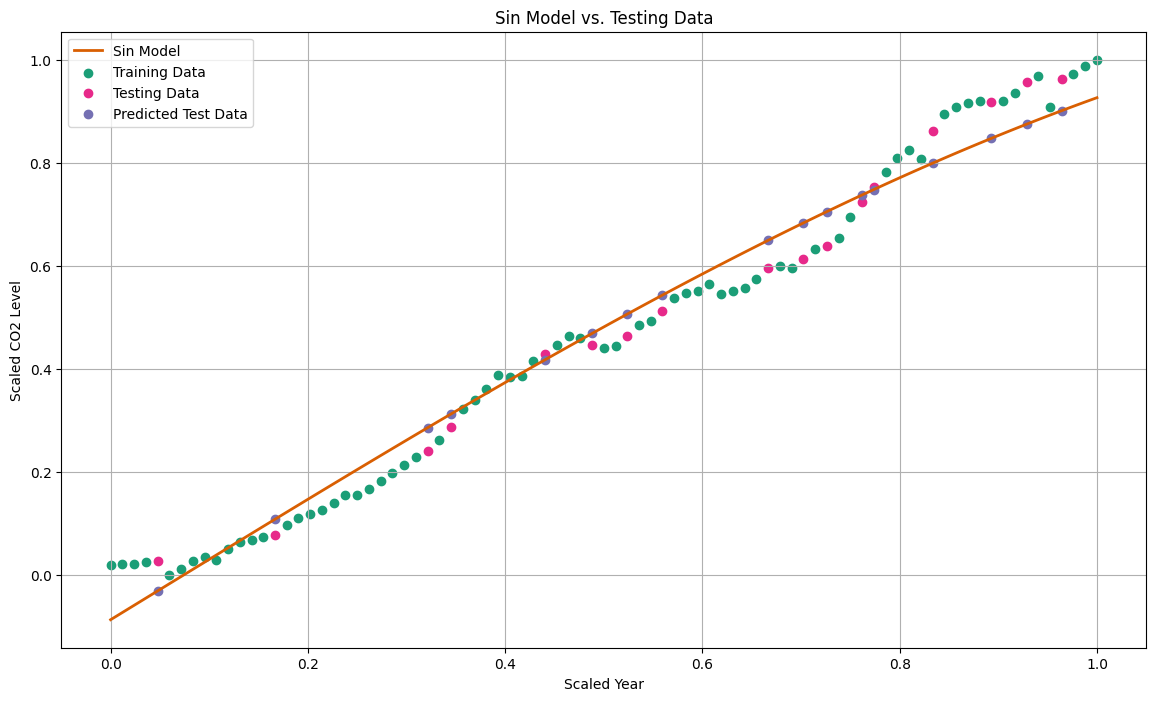

In [21]:
x = np.linspace(0, 1, 100)
y = sinModel(a, b, c, d, x)

# Evaluate the model on the test set
y_pred_test = sinModel(a, b, c, d, x_test)
test_loss = sinError(a, b, c, d, x_test, y_test)

# Print the test loss
print(f"Final Test Loss (MAE): {test_loss:.4f}")

# Plot the model's predictions against the test data
plt.figure(figsize=(14, 8))
plt.plot(x, y, linewidth=2, color='#d95f02', label='Sin Model')
plt.scatter(x_train_val, y_train_val, color='#1b9e77', label='Training Data')
plt.scatter(x_test, y_test, color='#e7298a', label='Testing Data')
plt.scatter(x_test, y_pred_test, color='#7570b3', label='Predicted Test Data')
plt.xlabel('Scaled Year')
plt.ylabel('Scaled CO2 Level')
plt.title('Sin Model vs. Testing Data')
plt.legend()
plt.grid(True)
plt.show()

The sinusoidal model performed well across all datasets, achieving a Mean Absolute Error (MAE) of 4.1% on the training set, 4.2% on the validation set, and 4.5% on the testing set. Although the errors are slightly higher than the linear model, the difference between them is minimal, which indicates that the sinusoidal model generalizes effectively to unseen data without significant overfitting or underfitting.

Final model:

$$ y = 1.19 \sin(0.99x - 0.04) - 0.037$$

The sinusoidal model captures the cyclical patterns in the CO2 emissions data, reflecting potential seasonal or periodic influences on global emissions. The amplitude of 1.19 and phase shift of 0.04 indicate the magnitude and timing of these oscillations, providing insights into the underlying dynamics of CO2 levels over time. 

---

### **Exponential Model**

The exponential model is defined as:

$$ y = a \cdot e^{bx} + c $$

In [22]:
# Exponential function
def expModel(a: float, b: float, c: float, x: np.ndarray) -> np.ndarray:
    return a * np.exp(b * x) + c

Setting arbitrary initial values for the parameters:

In [23]:
# Initial parameter values
a = 0.1
b = 2.5
c = -0.05

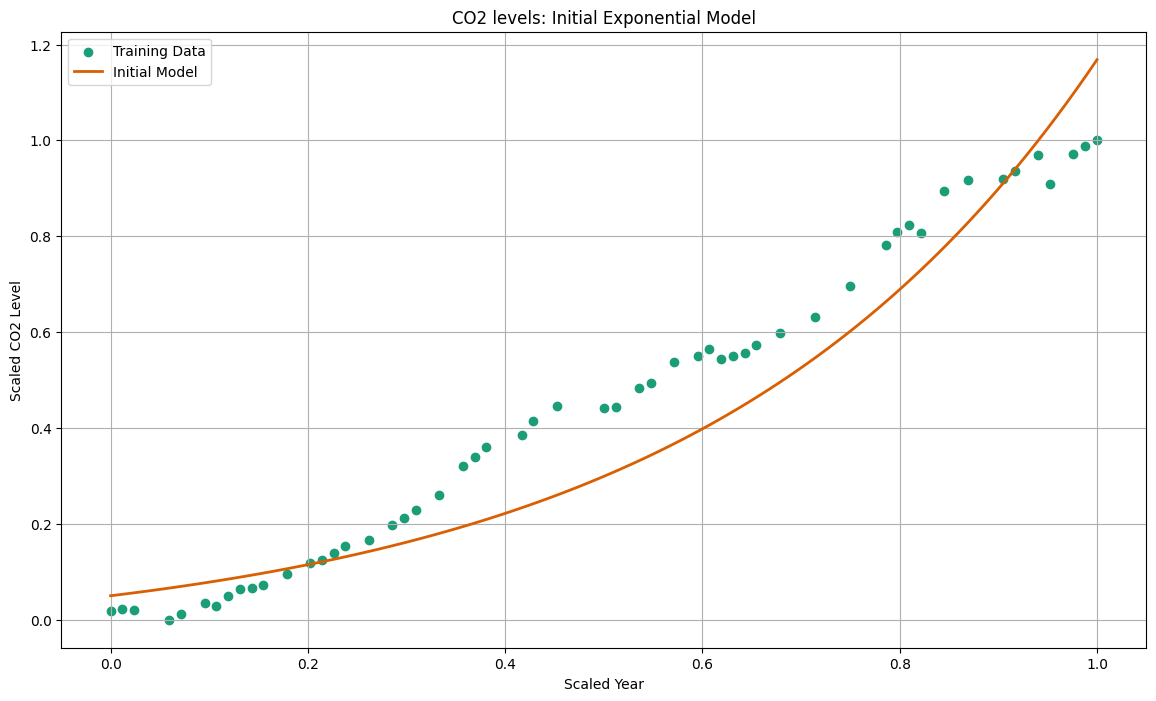

In [24]:
x = np.linspace(0, 1, 100)
y = expModel(a, b, c, x)

plt.figure(figsize = (14, 8))
plt.scatter(x_train, y_train, color = '#1b9e77', label = 'Training Data')
plt.plot(x, y, linewidth = 2, color = '#d95f02', label = 'Initial Model')
plt.xlabel('Scaled Year')
plt.ylabel('Scaled CO2 Level')
plt.title('CO2 levels: Initial Exponential Model')
plt.legend()
plt.grid(True)
plt.show()

This seems like a reasonable starting point for the exponential model. The next step is to optimize these parameters using gradient descent to minimize the Mean Absolute Error (MAE) between the predicted and actual CO2 levels.

#### **Gradient Descent**

We aim to minimize the Mean Absolute Error (MAE) between the predicted and actual CO2 levels. The MAE is defined as:

$$ E = \frac{1}{n} \sum_{i=1}^{n} |[a e^{bx_i} + c] - y_i| $$

In [25]:
def expError(a: float, b: float, c:float, x:np.ndarray, y:np.ndarray) -> float:
    return np.mean((np.abs(expModel(a, b, c, x) - y)))

The partial derivatives of the MAE with respect to $a$, $b$, and $c$ are computed as follows:


$$\frac{\partial E}{\partial a} = \frac{1}{n} \sum_{i=1}^{n} \text{sign} \left( [a e^{b x_i} + c] - y_i \right) \cdot e^{b x_i}$$



$$\frac{\partial E}{\partial b} = \frac{1}{n} \sum_{i=1}^{n} \text{sign} \left( [a e^{b x_i} + c] - y_i \right) \cdot a x_i e^{b x_i}$$



$$\frac{\partial E}{\partial c} = \frac{1}{n} \sum_{i=1}^{n} \text{sign} \left( [a e^{b x_i} + c] - y_i \right)$$


These gradients guide the update of $a$, $b$, and $c$ to decrease error.

Before starting the optimization loop, we define hyperparameters for the learning rate and number of iterations (epochs):

In [26]:
# Hyperparameters
learning_rate = 1E-3
epochs = 20

In [27]:
# Track losses
training_loss = []
validation_loss = []

# Gradient descent loop
for epoch in range(epochs):
    # Compute predictions for the training set
    y_pred_train = expModel(a, b, c, x_train)
    
    # Compute gradients
    da = np.mean(np.sign(y_pred_train - y_train) * np.exp(b * x_train))
    db = np.mean(np.sign(y_pred_train - y_train) * a * x_train * np.exp(b * x_train))
    dc = np.mean(np.sign(y_pred_train - y_train))
    
    # Update parameters
    a -= learning_rate * da
    b -= learning_rate * db
    c -= learning_rate * dc
    
    # Compute training loss
    loss = expError(a, b, c, x_train, y_train)
    training_loss.append(loss)
    
    # Compute validation loss
    y_pred_val = expModel(a, b, c, x_val)
    val_loss = expError(a, b, c, x_val, y_val)
    validation_loss.append(val_loss)
    
    # Log progress
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Training Loss = {loss:.4f}, Validation Loss = {val_loss:.4f}')
        
# Print final results
print("---------------------------------------")
print(f'Final Training Loss: {expError(a, b, c, x_train, y_train):.4f}')
print(f'Final Validation Loss: {expError(a, b, c, x_val, y_val):.4f}')
print(f'Optimized Parameters: a = {a:.4f}, b = {b:.4f}, c = {c:.4f}')

Epoch 0: Training Loss = 0.0857, Validation Loss = 0.0904
Epoch 5: Training Loss = 0.0813, Validation Loss = 0.0748
Epoch 10: Training Loss = 0.0779, Validation Loss = 0.0650
Epoch 15: Training Loss = 0.0777, Validation Loss = 0.0636
---------------------------------------
Final Training Loss: 0.0776
Final Validation Loss: 0.0632
Optimized Parameters: a = 0.1115, b = 2.5001, c = -0.0468


#### **Convergence Criteria**

To ensure the gradient descent algorithm has converged, we analyze the progression of the loss (error) on both the training and validation sets across epochs. Convergence is achieved when the losses stabilize, indicating that further iterations yield minimal improvement.

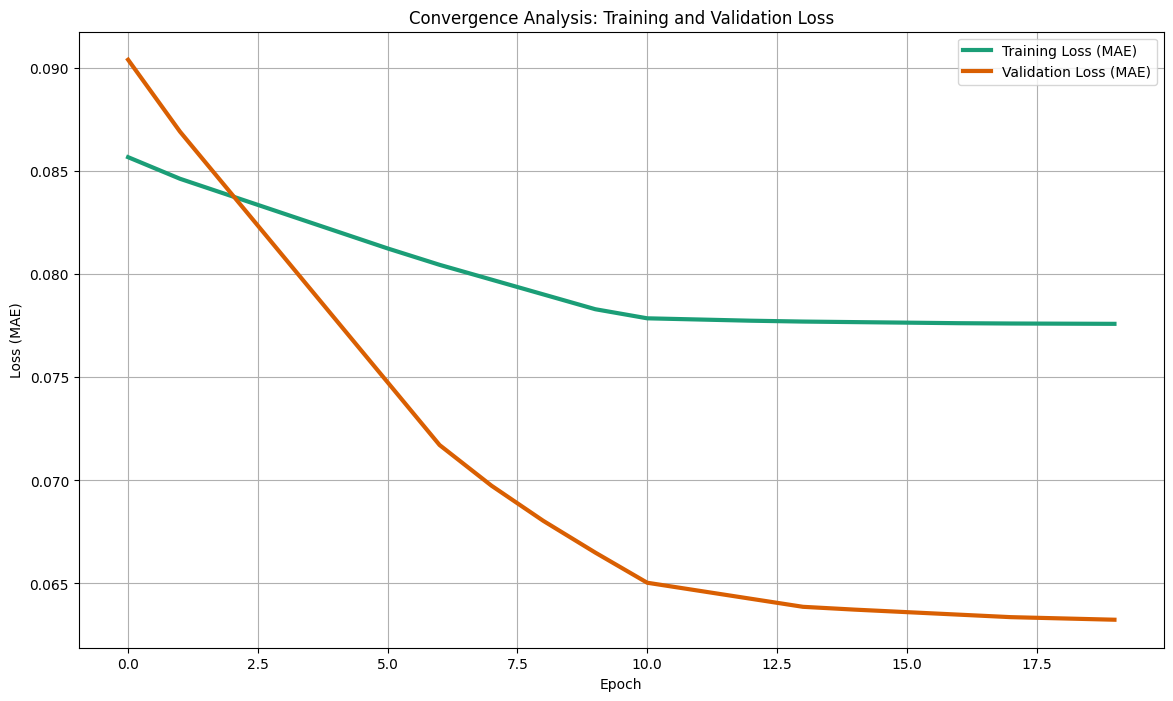

In [28]:
# Plot training and validation losses
plt.figure(figsize=(14, 8))
plt.plot(training_loss, label='Training Loss (MAE)', linewidth=3, color='#1b9e77')
plt.plot(validation_loss, label='Validation Loss (MAE)', linewidth=3, color='#d95f02')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Convergence Analysis: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

The error plot for the model shows that both training and validation losses decrease steadily and stabilize after approximately 10 epochs, indicating effective convergence. The validation loss decreases rapidly during the first few epochs and then flattens, demonstrating good generalization to unseen data without overfitting. The training loss remains slightly higher than the validation loss, which suggests that the model is robust and not memorizing noise in the training set. 

Although the gap between the sets are high, because of their stability, overfitting is not a huge concern, but there is more chance of it in compared to the linear and sinusoidal models. This might also well be due to variability or noise in the training set. Overall, the exponential model satisfies the convergence criteria and effectively captures the underlying trends in the data, making it a reasonable candidate for comparison with other models in this project.

#### **Model Testing & Error Analysis**

let's evaluate the exponential model's performance on the test set and calculate the Mean Absolute Error (MAE) to quantify the average deviation between predicted and actual CO2 levels.

Final Test Loss (MAE): 0.0725


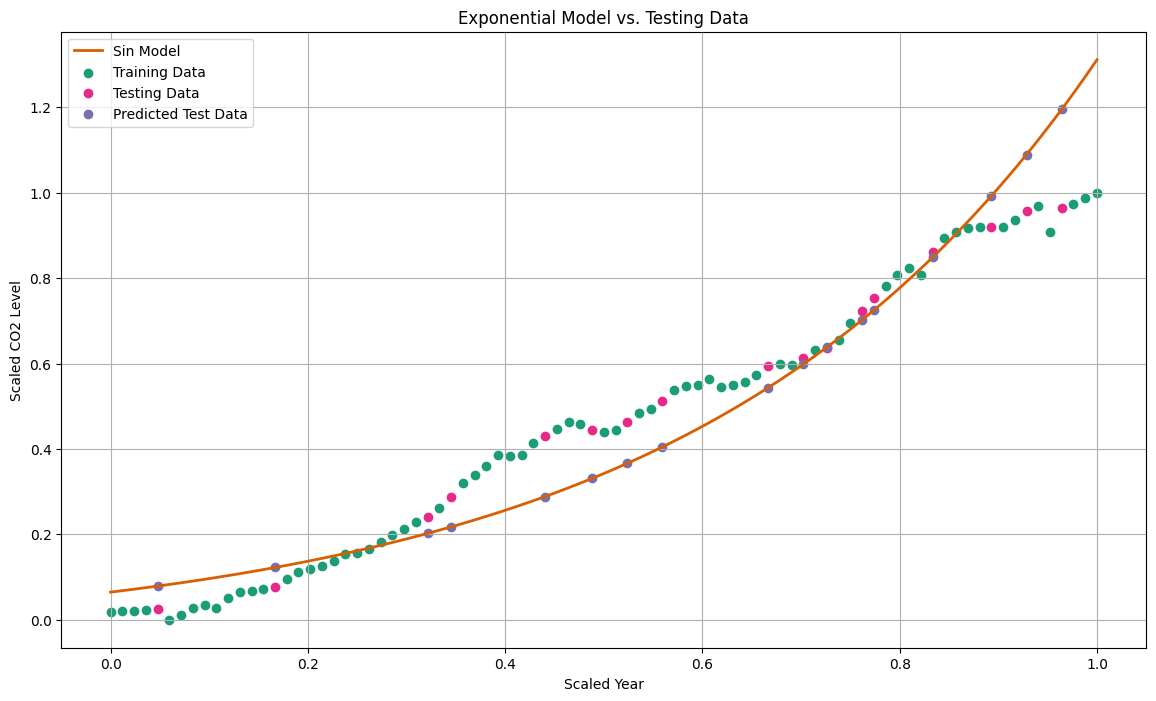

In [29]:
x = np.linspace(0, 1, 100)
y = expModel(a, b, c, x)

# Evaluate the model on the test set
y_pred_test = expModel(a, b, c, x_test)
test_loss = expError(a, b, c, x_test, y_test)

# Print the test loss
print(f"Final Test Loss (MAE): {test_loss:.4f}")

# Plot the model's predictions against the test data
plt.figure(figsize=(14, 8))
plt.plot(x, y, linewidth=2, color='#d95f02', label='Sin Model')
plt.scatter(x_train_val, y_train_val, color='#1b9e77', label='Training Data')
plt.scatter(x_test, y_test, color='#e7298a', label='Testing Data')
plt.scatter(x_test, y_pred_test, color='#7570b3', label='Predicted Test Data')
plt.xlabel('Scaled Year')
plt.ylabel('Scaled CO2 Level')
plt.title('Exponential Model vs. Testing Data')
plt.legend()
plt.grid(True)
plt.show()

As expected, the exponential model did not perform perfectly, achieving a Mean Absolute Error (MAE) of 7.8% on the training set, 6.3% on the validation set, and 7.2% on the testing set. Although this model is usable, the high errors and the significant difference between training, validation, and testing losses indicate that the exponential model does not generalize well to unseen data and is prone to overfitting.

Final model:

$$ y = 0.112 e^{2.5x} - 0.047 $$

Although the exponential model did not perform perfectly, it could be a strong candidate for a situation where an increase in population over years can lead to a shock in CO2 emissions, breaking linearaity. For example if new technology or demands created, require a sudden increase in energy consumption, this model can be a good fit.

---

### **Square Root Model**

The square root model is defined as:

$$ y = a \sqrt{bx + c} + d$$

In [30]:
# sqrt function
def sqrtModel(a: float, b: float, c:float, d:float, x: np.ndarray) -> np.ndarray:
    return a * np.sqrt(b * x + c) + d

Setting arbitrary initial values for the parameters:

In [31]:
# Initial parameter values
a = 0.95
b = 3.5
c = 0.4
d = -0.95

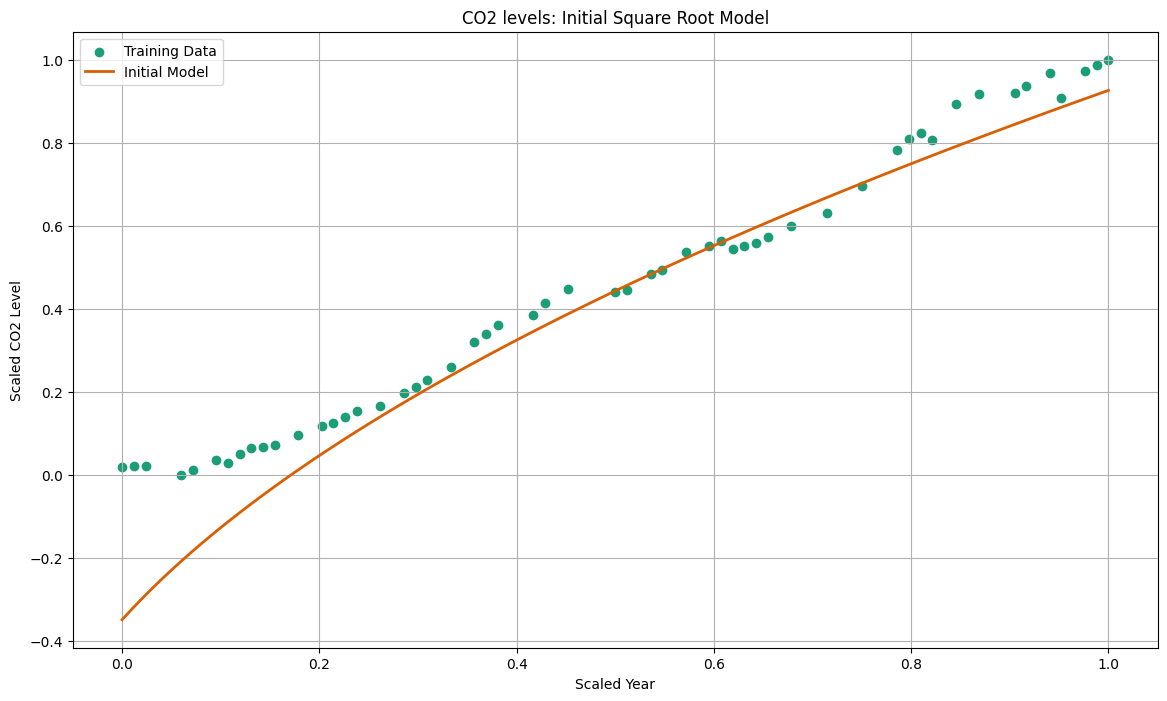

In [32]:
x = np.linspace(0, 1, 100)
y = sqrtModel(a, b, c, d, x)

plt.figure(figsize = (14, 8))
plt.scatter(x_train, y_train, color = '#1b9e77', label = 'Training Data')
plt.plot(x, y, linewidth = 2, color = '#d95f02', label = 'Initial Model')
plt.xlabel('Scaled Year')
plt.ylabel('Scaled CO2 Level')
plt.title('CO2 levels: Initial Square Root Model')
plt.legend()
plt.grid(True)
plt.show()

This seems like a reasonable starting point for the square root model. The next step is to optimize these parameters using gradient descent to minimize the Mean Absolute Error (MAE) between the predicted and actual CO2 levels.

#### **Gradient Descent**

We aim to minimize the Mean Absolute Error (MAE) between the predicted and actual CO2 levels. The MAE is defined as:

$$ E = \frac{1}{n} \sum_{i=1}^{n} |[a \sqrt{bx_i+c}+d] - y_i| $$

In [33]:
def sqrtError(a: float, b: float, c:float, d:float, x:np.ndarray, y:np.ndarray) -> float:
    return np.mean((np.abs(sqrtModel(a, b, c, d, x) - y)))

The partial derivatives of the MAE with respect to $a$, $b$, $c$, and $d$ are computed as follows:

$$\frac{\partial E}{\partial a} = \frac{1}{n} \sum_{i=1}^{n} \text{sign} \left( [a \sqrt{b x_i + c} + d] - y_i \right) \cdot \sqrt{b x_i + c}$$



$$\frac{\partial E}{\partial b} = \frac{1}{n} \sum_{i=1}^{n} \text{sign} \left( [a \sqrt{b x_i + c} + d] - y_i \right) \cdot \frac{a x_i}{2 \sqrt{b x_i + c}}$$



$$\frac{\partial E}{\partial c} = \frac{1}{n} \sum_{i=1}^{n} \text{sign} \left( [a \sqrt{b x_i + c} + d] - y_i \right) \cdot \frac{a}{2 \sqrt{b x_i + c}}$$



$$\frac{\partial E}{\partial d} = \frac{1}{n} \sum_{i=1}^{n} \text{sign} \left( [a \sqrt{b x_i + c} + d] - y_i \right)$$



These gradients guide the update of $a$, $b$, $c$, and $d$ to decrease error.

Before starting the optimization loop, we define hyperparameters for the learning rate and number of iterations (epochs):

In [34]:
# Hyperparameters
learning_rate = 1E-4
epochs = 400

In [35]:
# Track losses
training_loss = []
validation_loss = []

# Gradient descent loop
for epoch in range(epochs):
    # Compute predictions for the training set
    y_pred_train = sqrtModel(a, b, c, d, x_train)
    
    # Compute gradients
    da = np.mean(np.sign(y_pred_train - y_train) * np.sqrt(b * x_train + c))
    db = np.mean(np.sign(y_pred_train - y_train) * a * x_train / (2 * np.sqrt(b * x_train + c)))
    dc = np.mean(np.sign(y_pred_train - y_train) * a / (2 * np.sqrt(b * x_train + c)))
    dd = np.mean(np.sign(y_pred_train - y_train))

    
    # Update parameters
    a -= learning_rate * da
    b -= learning_rate * db
    c -= learning_rate * dc
    d -= learning_rate * dd
    
    # Compute training loss
    loss = sqrtError(a, b, c, d, x_train, y_train)
    training_loss.append(loss)
    
    # Compute validation loss
    y_pred_val = sqrtModel(a, b, c, d, x_val)
    val_loss = sqrtError(a, b, c, d, x_val, y_val)
    validation_loss.append(val_loss)
    
    # Log progress
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Training Loss = {loss:.4f}, Validation Loss = {val_loss:.4f}')
        
# Print final results
print("---------------------------------------")
print(f'Final Training Loss: {sqrtError(a, b, c, d, x_train, y_train):.4f}')
print(f'Final Validation Loss: {sqrtError(a, b, c, d, x_val, y_val):.4f}')
print(f'Optimized Parameters: a = {a:.4f}, b = {b:.4f}, c = {c:.4f}, d = {d:.4f}')

Epoch 0: Training Loss = 0.0764, Validation Loss = 0.0812
Epoch 100: Training Loss = 0.0686, Validation Loss = 0.0716
Epoch 200: Training Loss = 0.0643, Validation Loss = 0.0657
Epoch 300: Training Loss = 0.0627, Validation Loss = 0.0630
---------------------------------------
Final Training Loss: 0.0616
Final Validation Loss: 0.0612
Optimized Parameters: a = 0.9659, b = 3.5014, c = 0.4071, d = -0.9357


#### **Convergence Criteria**

To ensure the gradient descent algorithm has converged, we analyze the progression of the loss (error) on both the training and validation sets across epochs. Convergence is achieved when the losses stabilize, indicating that further iterations yield minimal improvement.

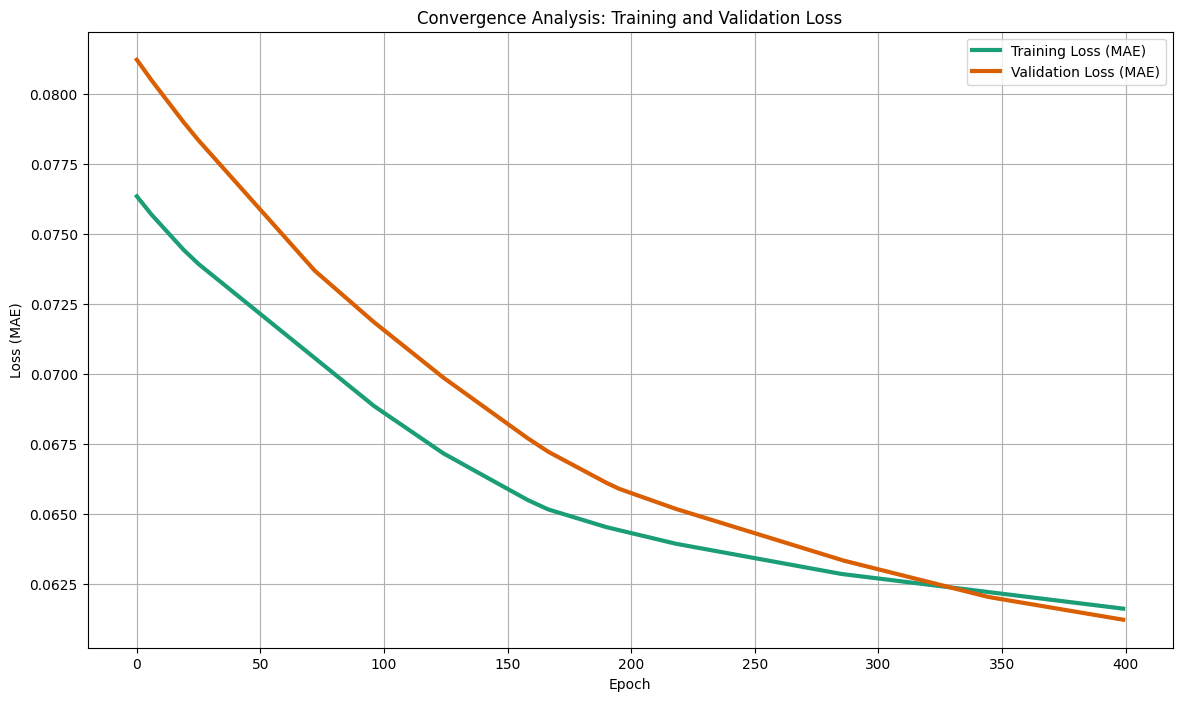

In [36]:
# Plot training and validation losses
plt.figure(figsize=(14, 8))
plt.plot(training_loss, label='Training Loss (MAE)', linewidth=3, color='#1b9e77')
plt.plot(validation_loss, label='Validation Loss (MAE)', linewidth=3, color='#d95f02')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Convergence Analysis: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

This is looking pretty good. The training and validation losses decrease steadily and stabilize after approximately 300 epochs, indicating effective convergence. The validation loss decreases rapidly during the first few epochs and then flattens, demonstrating good generalization to unseen data without overfitting. The training loss remains slightly higher than the validation loss, which suggests that the model is robust and not memorizing noise in the training set. The gap between them is also smaller than the exponential model, which is a good sign, indicating that the square root model generalizes better to unseen data, and has a lower risk of overfitting.

This outcome validates the chosen hyperparameters (learning rate, epochs) and confirms the stability of the optimization process.

#### **Model Testing & Error Analysis**

let's evaluate the exponential model's performance on the test set and calculate the Mean Absolute Error (MAE) to quantify the average deviation between predicted and actual CO2 levels.

Final Test Loss (MAE): 0.0508


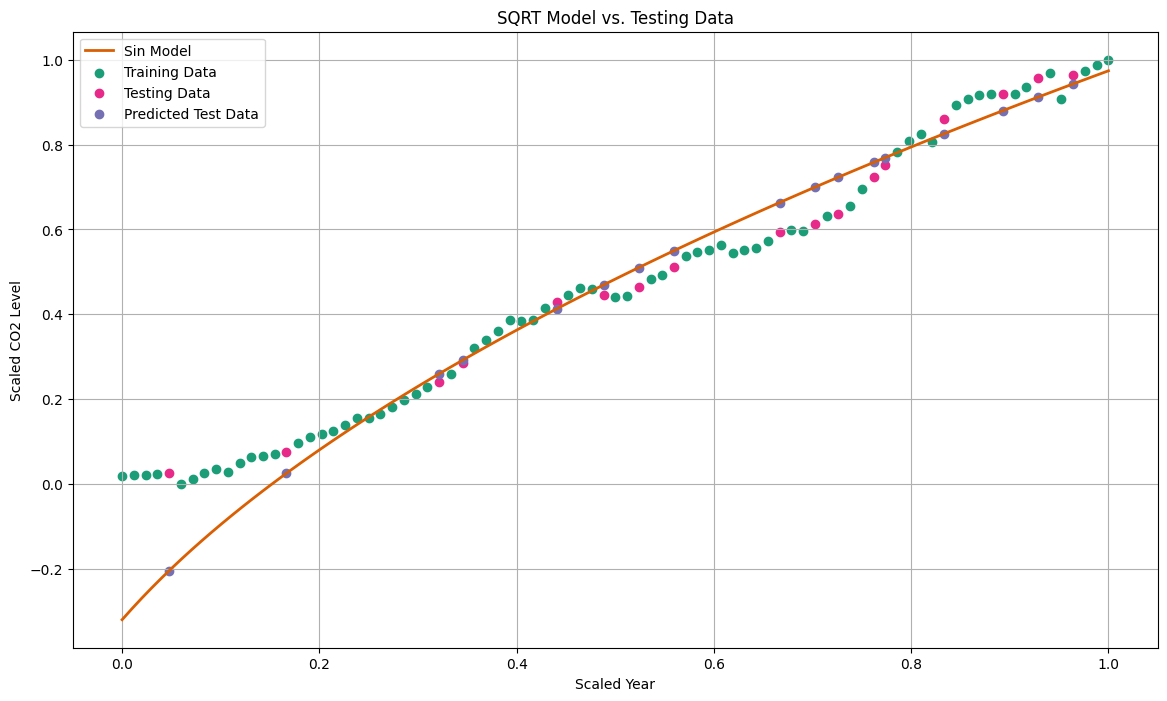

In [37]:
x = np.linspace(0, 1, 100)
y = sqrtModel(a, b, c, d, x)

# Evaluate the model on the test set
y_pred_test = sqrtModel(a, b, c, d, x_test)
test_loss = sqrtError(a, b, c, d, x_test, y_test)

# Print the test loss
print(f"Final Test Loss (MAE): {test_loss:.4f}")

# Plot the model's predictions against the test data
plt.figure(figsize=(14, 8))
plt.plot(x, y, linewidth=2, color='#d95f02', label='Sin Model')
plt.scatter(x_train_val, y_train_val, color='#1b9e77', label='Training Data')
plt.scatter(x_test, y_test, color='#e7298a', label='Testing Data')
plt.scatter(x_test, y_pred_test, color='#7570b3', label='Predicted Test Data')
plt.xlabel('Scaled Year')
plt.ylabel('Scaled CO2 Level')
plt.title('SQRT Model vs. Testing Data')
plt.legend()
plt.grid(True)
plt.show()

The square root model performed well across all datasets, achieving a Mean Absolute Error (MAE) of 6.2% on the training set, 6.1% on the validation set, and 5.1% on the testing set. The small difference between training, validation, and testing losses indicates that the square root model generalizes effectively to unseen data, with very little signs of significant overfitting or underfitting.

Final model:

$$ y = 0.966 \sqrt{3.501x + 0.41} - 0.936 $$

The square root model captures the decelerating growth rate in CO2 emissions over time, reflecting a potential slowdown in emissions as global dynamics shift. The square root model's ability to capture this nonlinear trend makes it a valuable addition to the analysis, providing insights into the changing patterns of CO2 levels and potential future trajectories.

---

## **Conclusion & Write-Up**

This analysis evaluates the performance of linear, sinusoidal, exponential, and square root models in capturing the global CO2 emissions trend. These models were chosen to explore a range of assumptions about emission growth dynamics, from steady increases to accelerating and decelerating patterns. Each model offers unique insights into emissions trends over time.

#### Linear & Sinusoidal Models:

The linear and sinusoidal models captured distinct aspects of CO2 emission trends. The linear model effectively represented the general upward trajectory, while the sinusoidal model excelled in capturing cyclical fluctuations. The sinusoidal model achieved lower errors across datasets and generalized better to unseen data, with reduced overfitting risk. However, its computational cost was significantly higher, requiring 800 epochs to converge compared to the linear model’s 40 epochs. For scenarios where computational resources are limited, the linear model offers a more practical alternative.

#### Exponential & Square Root Models:

The exponential and square root models were exploratory and based on distinct assumptions about emissions growth. The exponential model assumed accelerated growth driven by increasing per capita CO2 consumption, while the square root model captured decelerating growth, potentially reflecting transitions to greener technologies or shifts in energy consumption patterns.

The exponential model struggled with overfitting, showing higher errors and significant discrepancies between training, validation, and testing losses, indicating poor generalization. In contrast, the square root model achieved lower errors across all datasets, with minimal differences between losses, suggesting it generalized better and had a lower risk of overfitting. This makes the square root model more suited for scenarios involving decelerating growth trends.

#### **Final Thoughts:**

This analysis highlights that no single model emerges as the definitive choice. The sinusoidal model performed best overall, effectively capturing fluctuating patterns but at a high computational cost. The linear model was simple, interpretable, and computationally efficient, making it a practical option in resource-constrained scenarios. The square root model demonstrated versatility in capturing decelerating growth trends, which might be relevant for real-world shifts toward sustainable practices. While the exponential model performed poorly overall due to overfitting, it remains a valid option for specific scenarios involving rapid growth dynamics. Ultimately, the choice of model depends on the context, assumptions, and priorities of the analysis.

## **References**

- Wolfram Alpha (for calculating partial derivatives).

- AI (for refining text into clear, concise, correctly spelled explanations).

- Most of the code is inspired by the in-class notebooks.